# Part 1: import lib, dataset

In [200]:
import pandas as pd
import numpy as np
from timeit import time
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import scipy

In [2]:
df = pd.read_csv("Dataset/juno/product_feature5.csv")

In [3]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255
sku,130906,130906,130906,130908,130908,130908,130908,130908,130914,130914,...,VI129,VI130,VI130,VI130,VI131,VI131,VI131,VI132,VI132,VI132
productId,8585590533340,5606147680621,2125855072403,4549973884560,5107130473713,7344919573297,6162387995479,6036946488026,1591318751603,8759347822616,...,8935281555289,8935281555326,8935281555319,8935281555302,8935281555395,8935281555401,8935281555418,8935281555715,8935281555708,8935281555692
name,Giày Boot 130906 Đen 37 Si,Giày Boot 130906 Đen 36 Si,Giày Boot 130906 Đen 38 Si,Giày Búp Bê 130908 Xám 35 Si mờ,Giày Búp Bê 130908 Đen 35 Si mờ,Giày Búp Bê 130908 Xám 37 Si mờ,Giày Búp Bê 130908 Xám 36 Si mờ,Giày Búp Bê 130908 Xám 38 Si mờ,Giày Cao Gót 130914 Kem 38 Si bóng,Giày Cao Gót 130914 Đen 37 Si bóng,...,Ví VI129 Kem,Ví VI130 Hồng,Ví VI130 Đỏ,Ví VI130 Đen,Ví VI131 Đen,Ví VI131 Xanh,Ví VI131 Hồng,Ví VI132 Nâu,Ví VI132 Tím,Ví VI132 Đen
color,Đen,Đen,Đen,Xám,Đen,Xám,Xám,Xám,Kem,Đen,...,Kem,Hồng,Đỏ,Đen,Đen,Xanh,Hồng,Nâu,Tím,Đen
size,37,36,38,35,35,37,36,38,38,37,...,Mặc định,Mặc định,Mặc định,Mặc định,Mặc định,Mặc định,Mặc định,Mặc định,Mặc định,Mặc định
price,549000,549000,549000,299000,299000,299000,299000,299000,349000,349000,...,395000,435000,435000,435000,435000,435000,435000,305000,305000,305000
genres,Giày | Boot,Giày | Boot,Giày | Boot,Giày | Búp Bê,Giày | Búp Bê,Giày | Búp Bê,Giày | Búp Bê,Giày | Búp Bê,Giày | Cao Gót,Giày | Cao Gót,...,Ví,Ví,Ví,Ví,Ví,Ví,Ví,Ví,Ví,Ví
photo,http://hstatic.net/969/1000003969/1/2015/9-1/d...,http://hstatic.net/969/1000003969/1/2015/9-1/d...,http://hstatic.net/969/1000003969/1/2015/9-1/d...,http://hstatic.net/969/1000003969/1/2015/5-25/...,http://hstatic.net/969/1000003969/1/2015/7-2/d...,http://hstatic.net/969/1000003969/1/2015/5-25/...,http://hstatic.net/969/1000003969/1/2015/5-25/...,http://hstatic.net/969/1000003969/1/2015/5-25/...,http://hstatic.net/969/1000003969/1/2015/5-25/...,http://hstatic.net/969/1000003969/1/2015/5-25/...,...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...,https://product.hstatic.net/1000003969/product...
Function,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Office,Office,Office,Office,Office,Office,Office,Street Style,Street Style,Street Style
Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Basic,Basic,Basic,Basic,Main Stream,Main Stream,Main Stream,Basic,Basic,Basic


In [4]:
interact = pd.read_csv("Dataset/juno/interaction.csv")

In [5]:
interact.shape

(7662709, 4)

# Part 2: Validation data

* Note: 
1. problem with photo
2. problem with Function, Line, ThemeType, ProductMaterial, Material, Shape for same sku and color: product (1324 and 1327, 1213 and 1214) are different. But same remainings (photo, sku, color, price, ...)
3. Loai quai sau. product (3863 and 3868). Misunderstand: quai cổ chân-slingback. inspect photo, has no slingback but in df it does
4. genres: problem found 14415 and 14417, 14420 and 14421 genres. same photo, same sku, but: giày | sandle and giày | cao gót
3. In sumary, **4535/5505** type of product is valid. The invalid is caused by not fitting feature in section **.1**(not serious), **.2**, **.3** and **.4** (only 2 pair listed)
4. Conflit drop in Giay | Bup Be

In [7]:
df.columns

Index(['sku', 'productId', 'name', 'color', 'size', 'price', 'genres', 'photo',
       'Function', 'Line', 'ThemeType', 'ProductMaterial', 'Material',
       'FormFit', 'Shape', 'MiengTui', 'LoaiKhoaTui', 'BagLogo', 'LoaiDayDeo',
       'LoaiTayCam', 'BagInside', 'DeGiay', 'MuiGiay', 'ShoesHeight',
       'LoaiQuaiTruoc', 'LoaiQuaiSau', 'Decoration'],
      dtype='object')

In [14]:
cnt = 0
for i in range(len(df['LoaiQuaiSau'])):
    if df.loc[i, 'LoaiQuaiSau'] == 'Quai cổ chân': 
        df.loc[i, 'LoaiQuaiSau'] = 'Slingback'

(array([2116.,    0.,    0., 2791.,    0.,    0.,   58.,    0.,    0.,
         735.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

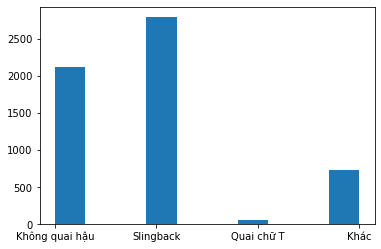

In [15]:
plt.hist([s for s in df['LoaiQuaiSau'] if str(s) != 'nan'])

In [26]:
t = [14415, 14417, 14420, 14421]
for i in t:
    df.loc[i, 'genres'] = 'Giày | Cao Gót'

In [30]:
for item in df.groupby(['sku', 'color']):
    for col in item[1].columns:
        if col in ['productId', 'name', 'size', 'price', 'photo']: continue
        for i in range(item[1].shape[0]):
            n1 = item[1].index[i]
            if str(item[1].loc[n1, col]) != 'nan':
                for j in range(item[1].shape[0]):
                    n2 = item[1].index[j]
                    if j != i:
                        df.loc[n2, col] = item[1].loc[n1, col]
                break

* Check feature of item in the same group of **sku** and **color**

In [32]:
cnt = 0
for item in df.groupby(['sku', 'color']):
    check = 1
    for i in range(item[1].shape[0]-1):
        cf = 1
        n1 = item[1].index[i]
        n2 = item[1].index[i+1]
        for col in item[1].columns:
            if col in ['productId', 'name', 'size', 'photo']: continue
            if str(item[1].loc[n1, col]) != str(item[1].loc[n2, col]):
                cf = 0
                break
        if cf == 0: 
            check = 0
            break
    if check: cnt += 1
print('%d/%d'%(cnt, len(df.groupby(['sku', 'color']))))

5505/5505


In [69]:
n_item = len(df.groupby(['sku', 'color']))

In [34]:
#df.to_csv("Dataset/juno/process/f5fixed.csv", index=False)

# Part 3: Group same kind of product

In [47]:
idx = dict()

In [ ]:
cnt = 0
for item in df.groupby(['sku', 'color']):
    for productId in item[1]['productId']:
        if productId not in idx:
            idx.update({productId: cnt})
    cnt += 1

# Par 4: Feature extraction

In [60]:
df.columns

Index(['sku', 'productId', 'name', 'color', 'size', 'price', 'genres', 'photo',
       'Function', 'Line', 'ThemeType', 'ProductMaterial', 'Material',
       'FormFit', 'Shape', 'MiengTui', 'LoaiKhoaTui', 'BagLogo', 'LoaiDayDeo',
       'LoaiTayCam', 'BagInside', 'DeGiay', 'MuiGiay', 'ShoesHeight',
       'LoaiQuaiTruoc', 'LoaiQuaiSau', 'Decoration'],
      dtype='object')

In [61]:
def getPriceRange(x):
    # 200 500 800 1000
    x /= 1000
    if x < 200: return 'price0'
    if x < 500: return 'price1'
    if x < 800: return 'price2'
    if x < 1000: return 'price3'
    return 'price4'

In [189]:
attr = []

* Attribue: price, genres, color, Function, Line ... (**col** variable)

In [190]:
col = ['price', 'genres', 'color', 'Function', 'Line', 'ThemeType', 'Material', 'FormFit', 'Shape', 'MiengTui', 'LoaiKhoaTui', 'BagLogo', 'LoaiDayDeo', 'LoaiTayCam', 'BagInside', 'DeGiay', 'MuiGiay', 'ShoesHeight', 'LoaiQuaiTruoc', 'LoaiQuaiSau', 'Decoration']
for item in df.groupby(['sku', 'color']):
    a = item[1].loc[item[1].index[0]]
    
    # get genres
    g = str(a['genres']).split(' | ')
    s = g[0].replace(' ', '').lower()
    if len(g) > 1:
        s += ' '+g[1].replace(' ', '').lower()
    #priceRange:
    s += ' '+getPriceRange(a['price'])
    # remainings
    for name in col[2:]:
        if str(a[name]) != 'nan':
            s += ' '+str(a[name]).replace(' ', '').lower()
    attr.append(s)

In [197]:
attr[500]

'giày búpbê price1 hồng office basic singleproduct simờtrơn fg52 balerina gótvuông mũinhọn 01cm slingback laserđụclỗ'

In [198]:
count = CountVectorizer(analyzer='word')
matrix = count.fit_transform(attr)
matrix

<5505x393 sparse matrix of type '<class 'numpy.int64'>'
	with 62792 stored elements in Compressed Sparse Row format>

In [201]:
scipy.sparse.save_npz('Dataset/juno/process/matrix_f5.npz', matrix)

In [202]:
print('Dense: %.5f' %(matrix.nnz/(matrix.shape[0]*matrix.shape[1])*100), '%')

Dense: 2.90238 %


In [211]:
log = list([])

In [212]:
start = time.time()
for n in range(1, 100):
    print(n)
    kmean = KMeans(n_clusters=n, random_state=0)
    kmean.fit(matrix)
    log.append(kmean.inertia_)
time.time()-start
# time taken: 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


2304.633036851883

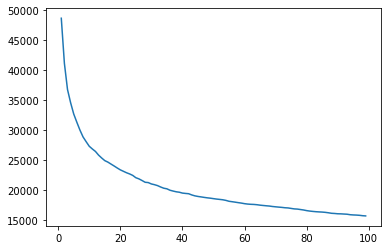

In [213]:
plt.plot(range(1, len(log)+1), log)

In [208]:
start = time.time()
kmean = KMeans(n_clusters=10, random_state=0)
kmean.fit(matrix)
time.time()-start

15.786655187606812

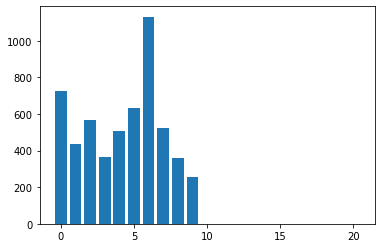

In [209]:
# this function show frequency of values of sets of elements provided by 'func' parameter
def showFrequency(val, func, left=0, right=0, lim=1000000007):
    f = np.zeros(right-left+1)
    for i in val: 
        res = func(i)-left
        if (res > -1 and res < len(f) and f[res]<lim): f[res] += 1
    plt.bar(np.arange(left, right+1), f)

showFrequency(kmean.labels_, lambda x: int(x), left=0, right=20)

In [210]:
np.save('Dataset/juno/process/10cluster/labels', kmean.labels_)
np.save('Dataset/juno/process/10cluster/centroids', kmean.cluster_centers_)

# Part 5: user

In [228]:
interact.shape

(7662709, 4)

In [229]:
interact = interact[interact['productId'].isin(df['productId'])]
interact = interact.sort_values(by=['timestamp'])

In [253]:
interact = interact.reset_index()

In [230]:
interact.shape

(7638602, 4)

* group user

In [231]:
start = time.time()
newUserId = []
userDict = dict()
cnt = 0
for uid in interact['userId']:
    if uid not in userDict:
        userDict.update({uid: cnt})
        cnt += 1
    newUserId.append(userDict[uid])
time.time()-start
# time taken: 9s

9.020415306091309

In [235]:
n_user = len(userDict)

In [262]:
start = time.time()
newItemId = []
for iid in interact['productId']:
    newItemId.append(idx[iid])
time.time()-start
# time taken: 4.7s

4.679101228713989

In [263]:
interact.insert(len(interact.columns), 'newUserId', newUserId)

In [265]:
interact.insert(len(interact.columns), 'newItemId', newItemId)

In [266]:
interact

,index,userId,productId,itemCount,timestamp,newUserId,newItemId
0,5755483,201511010001568,1061503010437,1,1429294412,0,106
1,5755482,201511010001568,1061503140436,1,1429294412,0,127
2,5755481,201511010001639,1061502020736,1,1429359970,1,77
3,5755480,201609302198805,1061502020637,1,1429381023,2,76
4,5755479,201609302198805,1061503050738,1,1429381023,2,118
...,...,...,...,...,...,...,...
7638597,1213557,201811160942889,8935281522656,1,1587678914,1280824,2653
7638598,1213556,201904121727024,8935281527781,1,1587678955,1501694,4246
7638599,1213555,201807202126336,8935281512794,1,1587678998,1112680,2645
7638600,1213554,201710122240549,8935281529181,1,1587679146,583082,2541


In [269]:
buylog = [[] for i in range(n_user)]
for i in range(len(interact)):
    buylog[interact.loc[i, 'newUserId']].append(int(interact.loc[i, 'newItemId']))

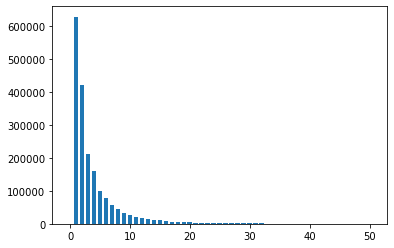

In [272]:
showFrequency(buylog, lambda x: len(x), left = 0, right = 50)

# Part 6: Making recommendation

* similarity = cosin

In [273]:
def calSimilarity(index1, index2): # derived from Betwen/processData/mas2
    res = 0
    # u and v are now numpy.ndarray
    u = li_indices[index1]
    v = li_indices[index2]
    lu = len(u)
    lv = len(v)
    if (lu > 0 and lv > 0):
        x = 0
        y = 0
        while (x < lu and y < lv):
            if u[x] == v[y]:
                x += 1
                y += 1
                res += 1
            else:
                if u[x] < v[y]:
                    x += 1
                else: y += 1
    if lv*lu == 0: return 0
    return res/np.sqrt(lv*lu)

* matrix csr to sorted list

In [274]:
li_indices = list([])
for i in range(matrix.shape[0]):
    li_indices.append(matrix[i].sorted_indices().indices)

In [275]:
labels = np.load("Dataset/juno/process/10cluster/labels.npy")

* group item to cluster

In [276]:
cluster = [[] for i in range(20)]

for i in range(len(labels)):
    cluster[labels[i]].append(i)

* indexInCluster[c][k]: in cluster c, index of item k. indexInCluster[c] = dict

In [277]:
indexInCluster = list([])
for k in range(len(cluster)):
    c = cluster[k]
    pos = dict()
    for i in range(len(c)):
        pos.update({c[i]: i})
    indexInCluster.append(pos)

#idx[labels[i]].append

* Calculate simialrity of item in same cluster

In [278]:
sim = [np.eye(len(i)) for i in cluster]

In [279]:
start = time.time()

for k in range(len(cluster)):
    c = cluster[k]
    for i in range(len(c)):
        for j in range(len(c)):
            if j < i:
                sim[k][i][j] = sim[k][j][i]
            elif i < j:
                sim[k][i][j] = calSimilarity(c[i], c[j])

print(time.time()-start)

47.62920379638672


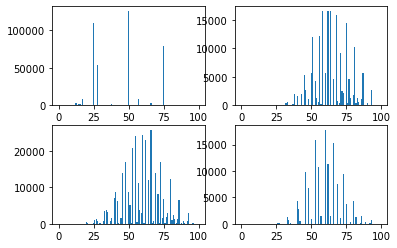

In [281]:
for i in range(0, 4):
    plt.subplot(220+i+1)
    showFrequency(sim[i].flatten(), lambda x: int(x*100), left=1, right=99)

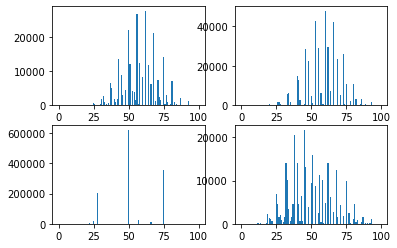

In [282]:
for i in range(0, 4):
    plt.subplot(220+i+1)
    showFrequency(sim[i+4].flatten(), lambda x: int(x*100), left=1, right=99)

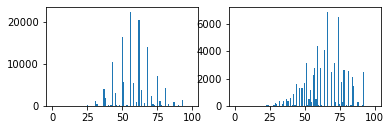

In [283]:
for i in range(0, 2):
    plt.subplot(220+i+1)
    showFrequency(sim[i+8].flatten(), lambda x: int(x*100), left=1, right=99)

In [284]:
print(n_user, n_item)

1904342 5505


In [285]:
def feed(I):
    pred[I] = -1
    c = labels[I]
    idxI = indexInCluster[c][I]
    for J in cluster[c]:
        if pred[J] != -1:
            pred[J] += sim[c][idxI, indexInCluster[c][J]]

In [ ]:
start = time.time()

top = 50
p = np.zeros(top+1)
trainRate = 0.8

userRecommend = n_user

userEvaLog = []

# feed means training that item for a user
for user in range(userRecommend): # number of user ###
    if user%10000 == 0:
        print("feeding user %d" %(user))
    if len(buylog[user]) < 5:
        continue
    l = int(trainRate*len(buylog[user]))
    pred = np.zeros(n_item)
    
    for item in buylog[user][:l]:
        feed(item)

    rec = [(pred[item], item) for item in range(n_item)] ###
    rec = sorted(rec, reverse=True)[:top]
    
    optPos = -1
    for i in range(len(rec)):
        k = rec[i][1]
        if k in [j for j in buylog[user][l:]]:
            optPos = i
            break
    p[optPos] += 1
    if optPos != -1 and len(userEvaLog) < 20:
        userEvaLog.append((user, rec, optPos, l)) #(newUserId, reccommend list, optimal rank, partition position train-test)

end = time.time()
print(end-start)
#time taken: 8488.404755353928

<BarContainer object of 50 artists>

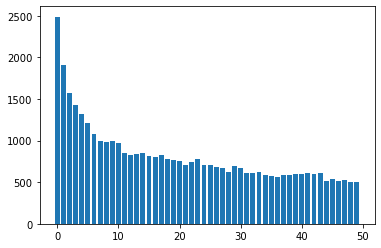

In [290]:
plt.bar(np.arange(0, len(p)-1), p[:len(p)-1])

In [291]:
list_top = [5, 10, 20, 50]
score = list()
for t in list_top:
    hr = np.sum(p[:t])/np.sum(p)
    mrr = np.sum([0 if i >= t else p[i]/(i+1) for i in range(len(p))])/np.sum(p)
    score.append([hr, mrr])

In [292]:
pd.DataFrame(score, index=['Top '+str(i) for i in list_top], columns=['Hit rate', 'MRR'])

,Hit rate,MRR
Top 5,0.018067,0.009511
Top 10,0.029018,0.010945
Top 20,0.046296,0.012113
Top 50,0.084828,0.013305


In [300]:
start = time.time()

top = 50
p = np.zeros(top+1)
trainRate = 0.8

userRecommend = n_user

userEvaLog1 = []

# feed means training that item for a user
for user in range(userRecommend): # number of user ###
    #if user%10000 == 0:
        #print("feeding user %d" %(user))
    if len(buylog[user]) < 3:
        continue
    l = int(trainRate*len(buylog[user]))
    pred = np.zeros(n_item)
    
    for item in buylog[user][:l]:
        feed(item)

    rec = [(pred[item], item) for item in range(n_item)] ###
    rec = sorted(rec, reverse=True)[:top]
    
    optPos = -1
    for i in range(len(rec)):
        k = rec[i][1]
        if k in [j for j in buylog[user][l:]]:
            optPos = i
            break
    p[optPos] += 1
    #if optPos != -1 and len(userEvaLog) < 20:
        #userEvaLog1.append((user, rec, optPos, l)) #(newUserId, reccommend list, optimal rank, partition position train-test)

end = time.time()
print(end-start)
#time taken: 8488.404755353928

11817.805243253708


<BarContainer object of 50 artists>

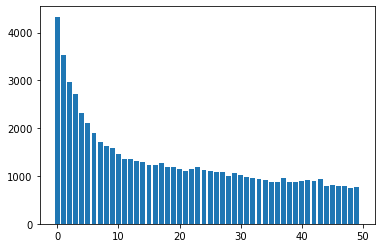

In [301]:
plt.bar(np.arange(0, len(p)-1), p[:len(p)-1])

In [302]:
list_top = [5, 10, 20, 50]
score = list()
for t in list_top:
    hr = np.sum(p[:t])/np.sum(p)
    mrr = np.sum([0 if i >= t else p[i]/(i+1) for i in range(len(p))])/np.sum(p)
    score.append([hr, mrr])

In [303]:
pd.DataFrame(score, index=['Top '+str(i) for i in list_top], columns=['Hit rate', 'MRR'])

,Hit rate,MRR
Top 5,0.018574,0.009634
Top 10,0.029067,0.011016
Top 20,0.044142,0.012035
Top 50,0.077734,0.013077


* visualize recommendation

In [321]:
# userEvaLog = [(newUserId, rec=(pred, newItemId), rank, partitionLen)]
for user, rec, rank, l in userEvaLog:
    for i in range(len(interact)):
        if interact.loc[i, 'newUserId'] == user:
            print('userId ', interact.loc[i, 'userId'])
            break
    print('train ', buylog[user][:l])
    print('test ', buylog[user][l:])
    k = rank
    if k < 5: k = 5
    print('rec ', [x[1] for x in rec[:k+1]])
    print('rank ', rank)
    print()

userId  201511010000789
train  [46, 76, 430, 431]
test  [429]
rec  [429, 422, 419, 421, 420, 610]
rank  0

userId  201511010002925
train  [105, 1120, 3491, 1094, 3113, 2886, 2736, 2026]
test  [2738, 2906]
rec  [2826, 2803, 2677, 2828, 2739, 2713, 2684, 2885, 2827, 2804, 2802, 2782, 2738]
rank  12

userId  201511010001375
train  [79, 2681, 2684, 1101, 5208, 2615, 2615]
test  [2484, 2764]
rec  [2828, 2739, 2827, 2826, 2804, 2803, 2802, 2738, 2735, 2713, 2711, 2710, 2709, 2708, 2707, 2706, 2683, 2680, 2679, 2678, 2677, 2676, 2675, 2674, 2614, 2613, 2783, 2742, 2737, 2736, 2714, 2782, 2781, 2634, 2631, 2607, 3167, 3160, 3159, 3057, 3053, 2885, 2839, 2831, 2822, 2821, 2764]
rank  46

userId  201511010001602
train  [125, 2964, 82, 85, 2279, 2278, 2280, 126, 2964, 1497, 88, 2278, 2284, 2276, 1496, 2275, 126]
test  [2278, 88, 2282, 127, 1221]
rec  [3188, 3048, 3029, 3023, 3017, 3013, 3010, 3006, 2982, 2971, 2864, 2861, 2852, 2849, 2671, 2588, 2408, 2394, 2385, 2338, 2335, 2324, 2302, 2299, 229

In [333]:
lis = [([46, 76, 430, 431], [429, 422, 419, 421, 420, 610], 0), 
       ([105, 1120, 3491, 1094, 3113, 2886, 2736, 2026], [2826, 2803, 2677, 2828, 2739, 2713, 2684, 2885, 2827, 2804, 2802, 2782, 2738], 12), 
       ([2273, 1076, 430, 444, 444, 2394, 2431, 2749, 659, 1362, 3957, 1368], [525, 607, 523, 433, 415, 413, 426, 502, 537, 490, 480, 583, 526, 524, 361, 722, 716, 731], 17), 
       ([159, 2121, 2127, 2125], [2137, 2122, 2119, 2116, 2114, 2108], 2), 
      ([94, 4593, 3056, 4783, 1930, 3054, 3159, 4179, 4997, 2652, 707, 3160], [3167, 3057, 3053, 3166, 3164, 3158, 3058], 6)]

In [325]:
lphoto = []
for item in df.groupby(['sku', 'color']):
    lphoto.append(item[1].loc[item[1].index[0], 'photo'])

In [334]:
for train, rec, rank in lis:
    print('train')
    for index_gr in train:
        print(lphoto[index_gr])
    print('rec')
    for index_gr in rec:
        print(lphoto[index_gr])
    print('rank: ', rank)
    print()

train
http://hstatic.net/969/1000003969/1/2015/5-25/xanh-duong__6__a589f10d-ad37-4232-4c5a-1b6dca2b4c1f_92caf914-a7f4-4e75-57f5-6ae911c49590_2979967f-4e_e8ee10a8-476d-48e5-6e47-c6d9ac162fe8.png
http://hstatic.net/969/1000003969/1/2015/5-25/hong__2__1f41fb8f-c185-48d2-77a7-a7fdc3736236_24e1f84d-0b01-4785-7ba8-df383efb3aa7_90540e70-48fc-409_5df504c7-1cd4-4526-49e8-a80b87629fab.png
http://product.hstatic.net/1000003969/product/den_bb01075_2_.jpg
http://product.hstatic.net/1000003969/product/do_bb01075_2_.jpg
rec
http://product.hstatic.net/1000003969/product/kem_bb01075_2_.jpg
http://product.hstatic.net/1000003969/product/den_79_.jpg
http://product.hstatic.net/1000003969/product/do_20_618_.jpg
http://product.hstatic.net/1000003969/product/nau_90_.jpg
http://product.hstatic.net/1000003969/product/kem_60_.jpg
https://product.hstatic.net/1000003969/product/den-bb01133-2_8e9be4bc7b36467f8aede2a5af19daef.jpg
rank:  0

train
http://hstatic.net/969/1000003969/1/2015/7-2/den__2__72cfef50-6e13-476e